In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from orix.quaternion import Rotation
from pathlib import Path
import kikuchipy as kp
from openECCI import util, io, rkp, optimisation, stagecomputation

plt.rcParams.update({
    "figure.figsize": (7, 7),
    "font.size": 9,
})

In [2]:
# Path to Si ECP reference pattern
si_ref_ecp_path = r"D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20231024 ECCI"
si_ref_ecp_file = r"01_Si_003_after 180 rot.tif"
si_ref_ecp_fname = os.path.join(si_ref_ecp_path, si_ref_ecp_file)
ref_ecp = plt.imread(si_ref_ecp_fname)

# Path to Si ECP experimental pattern
si_exp_ecp_path = r"D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20231024 ECCI"
si_exp_ecp_file = r"01_Si_003_after 180 rot.tif"
si_exp_ecp_fname = os.path.join(si_exp_ecp_path, si_exp_ecp_file)
experiment_ecp = plt.imread(si_exp_ecp_fname)

# Path to Si master pattern generated by EMsoft
si_MP_path = Path(r"C:\Users\IMBalENce\EMsoftData")
si_MP_file = r"Si-master-20kv.h5"
si_MP_fname = os.path.join(si_MP_path, si_MP_file)
# si_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)
si_ECP_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to Si .ctf file containing the EBSD euler angles
si_xmap_path = r"D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20221216 EBSD standard steel\standard steel sample 14_12_2022\standard fcc steel"
si_xmap_file = r"20kv_26nA_15mm WD_4x4 binning Si Map Data 2.ctf"
si_xmap_fname = os.path.join(si_xmap_path, si_xmap_file)

(-0.5, 1023.5, 883.5, -0.5)

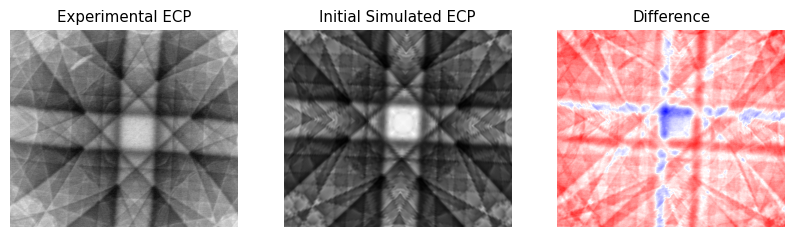

In [3]:
%matplotlib inline
# Get a approximate guess on the optimization parameters
tiltX_corr_angle = 0.1 # positive direction => pattern moves LEFT
tiltY_corr_angle = 0.5  # positive direction => pattern moves DOWN
tiltZ_corr_angle = 0 # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz = 4 # Larger value => smaller angular range

# get the stage rotation and tilt relative to the reference ECP
# angles used here are according to the testing reference frame rather than the SEM software rotation and tilt
st_rot_angle, st_tilt_angle = stagecomputation.get_relative_stage_pos(si_ref_ecp_fname, si_exp_ecp_fname)

# convert the stage rotation and tilt to Rotation objects
# the negative sign is used because the stage rotation and tilt active rotations. 
# In EBSD, rotations are usually in passive form according to Bunge convention
st_rot = Rotation.from_axes_angles(axes = [0, 0, 1], 
                                   angles = -st_rot_angle, 
                                   degrees = True)
st_tilt = Rotation.from_axes_angles(axes = [0, 1, 0], 
                                    angles = -st_tilt_angle, 
                                    degrees=True)

# read the average orientation of Si EBSD map
# si_average_rotation = get_avg_orientation(si_xmap_fname) * Rotation.from_axes_angles([0, 0, 1], -np.pi / 2)
si_average_rotation = io.get_avg_orientation(si_xmap_fname)
ecp_resolution = io.get_sem_metadata(si_ref_ecp_fname)["resolution"]

# simulate the ECP using the initial guess
sim_RKP_initial = rkp.get_sim_rkp(RKP_masterpattern = si_ECP_MP,
                              xtal_rotation = si_average_rotation,
                              st_rot_angle=0,
                              st_tilt_angle=0,
                              corr_angles=[tiltX_corr_angle, tiltY_corr_angle, tiltZ_corr_angle],
                              ref_ECP=si_ref_ecp_fname,
                              cam_length=PCz,
                              RKP_shape=ecp_resolution)

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
ax1.imshow(ref_ecp[:ecp_resolution[1],:], cmap='gray')
ax1.set_title("Experimental ECP")
ax1.axis("off")

ax2.imshow(np.squeeze(sim_RKP_initial.data), cmap='gray')
ax2.set_title("Initial Simulated ECP")
ax2.axis("off")

ax3.imshow(util.normalize(ref_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP_initial.data)), cmap='bwr')
ax3.set_title("Difference")
ax3.axis("off")

In [4]:
a = optimisation.orientation_calibration(corr_angles=[tiltX_corr_angle, tiltY_corr_angle, tiltZ_corr_angle],
                            PCz=PCz,
                            reference_ECP_path=si_ref_ecp_fname,
                            si_master_pattern=si_ECP_MP,
                            Si_xtal=si_average_rotation)

Orientation Calibration Object created using the following parameters:               
Initial guess corrections: {'tiltX_corr_angle': 0.1, 'tiltY_corr_angle': 0.5, 'tiltZ_corr_angle': 0, 'PCz': 4},              
Reference ECP: D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20231024 ECCI\01_Si_003_after 180 rot.tif,              
Master Pattern: <EBSDMasterPattern, title: C:\Users\IMBalENce\EMsoftData\Si-master-20kv, dimensions: (2|1001, 1001)>


In [5]:
optimized_results = a.optimize_calibration(method="NDP")

Optimization terminated successfully.
         Current function value: 0.035442
         Iterations: 165
         Function evaluations: 317
Rotation calibration optimized using NDP method
tiltX_corr_angle: -0.5312103261068537, tiltY_corr_angle: 1.2285403872457656, tiltZ_corr_angle: 0.06380671840706255 PCz: 3.890243796249578
NDP: 0.9645581053982366


Calibration of orientation correction coefficients:
{'tiltX_corr_angle': -0.5312103261068537, 'tiltY_corr_angle': 1.2285403872457656, 'tiltZ_corr_angle': 0.06380671840706255, 'PCz': 3.890243796249578}


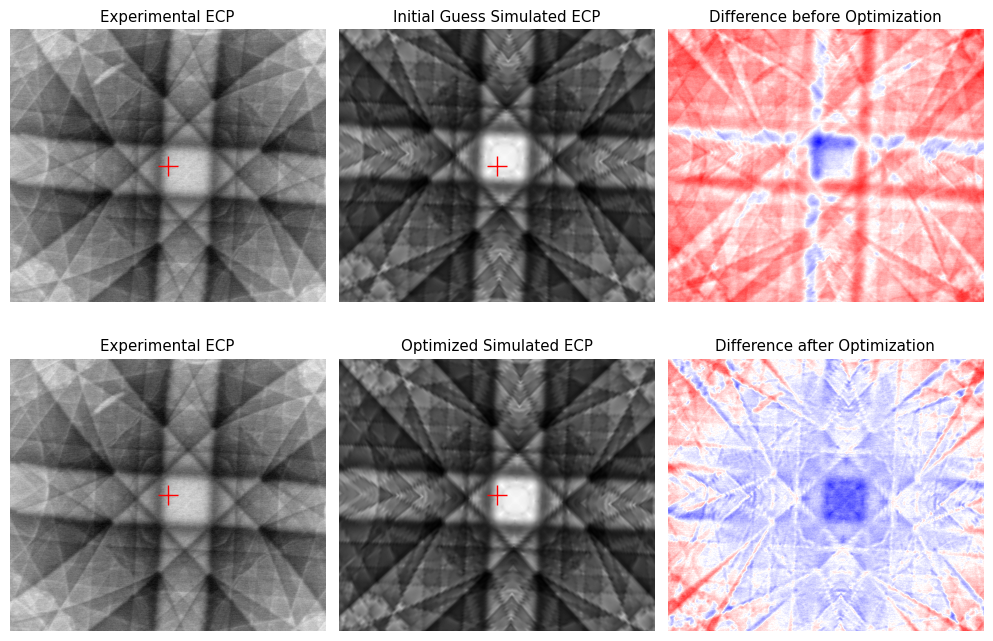

In [6]:
%matplotlib inline

tiltX_corr_angle_op = optimized_results["tiltX_corr_angle"] # positive direction => pattern moves DOWN
tiltY_corr_angle_op = optimized_results["tiltY_corr_angle"] # positive direction => pattern moves LEFT
tiltZ_corr_angle_op = optimized_results["tiltZ_corr_angle"] # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz_op = optimized_results["PCz"] # Larger value => smaller angular range

# get the stage rotation and tilt relative to the reference ECP
# angles used here are according to the testing reference frame rather than the SEM software rotation and tilt
st_rot_angle, st_tilt_angle = stagecomputation.get_relative_stage_pos(si_ref_ecp_fname, si_ref_ecp_fname)

# convert the stage rotation and tilt to Rotation objects
# the negative sign is used because the stage rotation and tilt active rotations. 
# In EBSD, rotations are usually in passive form according to Bunge convention
st_rot = Rotation.from_axes_angles(axes = [0, 0, 1], 
                                   angles = -st_rot_angle, 
                                   degrees = True)
st_tilt = Rotation.from_axes_angles(axes = [0, 1, 0], 
                                    angles = -st_tilt_angle, 
                                    degrees=True)

# simulate the ECP using the initial guess
sim_RKP_optimized = rkp.get_sim_rkp(RKP_masterpattern = si_ECP_MP,
                              xtal_rotation = si_average_rotation,
                              st_rot_angle=0,
                              st_tilt_angle=0,
                              corr_angles=[tiltX_corr_angle_op, tiltY_corr_angle_op, tiltZ_corr_angle_op],
                              ref_ECP=si_ref_ecp_fname,
                              cam_length=PCz_op,
                              RKP_shape=ecp_resolution)

fig1, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,7))

axs[0,0].imshow(ref_ecp[:ecp_resolution[1],:], cmap='gray')
axs[0,0].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[0,0].set_title("Experimental ECP")
axs[0,0].axis("off")

axs[0,1].imshow(np.squeeze(sim_RKP_initial.data), cmap='gray')
axs[0,1].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[0,1].set_title("Initial Guess Simulated ECP")
axs[0,1].axis("off")

axs[0,2].imshow(util.normalize(ref_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP_initial.data)), cmap='bwr')
axs[0,2].set_title("Difference before Optimization")
axs[0,2].axis("off")

axs[1,0].imshow(ref_ecp[:ecp_resolution[1],:], cmap='gray')
axs[1,0].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,0].set_title("Experimental ECP")
axs[1,0].axis("off")

axs[1,1].imshow(np.squeeze(sim_RKP_optimized.data), cmap='gray')
axs[1,1].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,1].set_title("Optimized Simulated ECP")
axs[1,1].axis("off")

axs[1,2].imshow(util.normalize(ref_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP_optimized.data)), cmap='bwr')
axs[1,2].set_title("Difference after Optimization")
axs[1,2].axis("off")

plt.tight_layout()

print(f"Calibration of orientation correction coefficients:\n{optimized_results}")